# Limpieza

In [1]:
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report



stopwords = set(stopwords.words('english'))

c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datos = pd.read_csv('dataset/final-train.csv')
datos.head()

,Summary,Text,Score
0,Can really notice when I am not drinking it,I have had hormone problems in the past couple...,5
1,"Okay, just not the best",This is a decent balsamic glaze/reducation.<br...,4
2,"goo source of fiber, not so much a source of c...",the cookie is moist and chewy and has a great ...,3
3,Great GF Staple,I have a 4 yr old and a 2 yr old that can't ea...,5
4,Coffee just doesn't taste right without Sweet ...,We have drunk our coffee for 45 years using th...,5


In [3]:
# Vemos la primera entrada de la columna 'text' y la columna 'summary'
print(datos['Text'][1])

This is a decent balsamic glaze/reducation.<br /><br />It has a faint yeasty taste that I don't care for...not so heavy to preclude using it again, but I have a different brand that I love love love, so this is just a back up.<br /><br />FYI try Blaze balsamic reduction/glaze.  It is superb.


In [4]:
print(datos['Summary'][0])

Can really notice when I am not drinking it


In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  426323 non-null  object
 1   Text     426340 non-null  object
 2   Score    426340 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.8+ MB


In [6]:
def limpiar_datos(dataframe):
    dataframe = dataframe.copy().dropna()
    dataframe['FullText'] = dataframe['Summary'] + ' ' + dataframe['Text']
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'<.*?>', '', regex=True)
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'\d+', '', regex=True)
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'[^\w\s]', ' ', regex=True).str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

    dataframe = dataframe[['FullText','Score']]

    return dataframe

In [7]:
datos_limpio = limpiar_datos(datos)

In [8]:
print(datos_limpio['FullText'][1])

okay best decent balsamic glaze reducation faint yeasty taste care heavy preclude using different brand love love love back fyi try blaze balsamic reduction glaze superb


In [9]:
datos_limpio.head()

,FullText,Score
0,really notice drinking hormone problems past c...,5
1,okay best decent balsamic glaze reducation fai...,4
2,goo source fiber much source chocoate cookie m...,3
3,great gf staple yr old yr old eat gluten aweso...,5
4,coffee taste right without sweet n low drunk c...,5


## Entrenamiento

In [10]:
map_dict = {1: 0, 2:0, 3:1, 4:1, 5:1}

datos_limpio['Label'] = datos_limpio['Score'].map(map_dict)
datos_limpio.sample(10)

,FullText,Score,Label
181259,favorite delivery extremely quick packaging fi...,2,0
97103,say something friend mine gave small bag quali...,5,1
368543,great product bad business ordering royal cani...,1,0
343348,dark chocolate hmmm bitter according everybody...,5,1
85751,works well recommended clear scalp hair strong...,4,1
160161,dog loved expected bigger dog loved happy thin...,4,1
153983,best salami best salami made find locally amaz...,5,1
17924,taste like columbian coffee bitter oily would ...,2,0
341110,shiro miso soup kikkoman instant shiro miso wh...,5,1
355197,favorite husband like soup although lower sodi...,5,1


<Axes: ylabel='Frequency'>

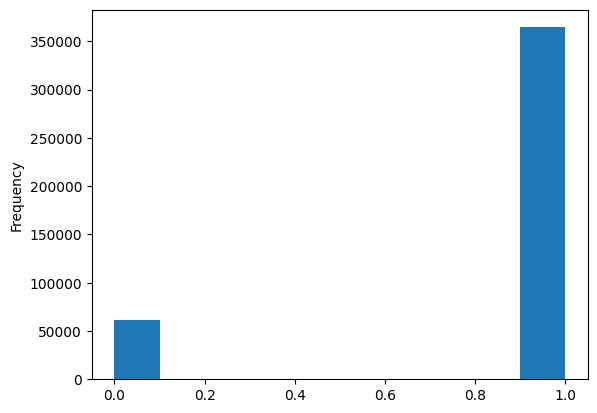

In [11]:
datos_limpio['Label'].plot(kind='hist')

In [12]:
datos_pos = datos_limpio[datos_limpio['Label'] == 1].sample(100000)
datos_neg = datos_limpio[datos_limpio['Label'] == 0]

In [13]:
datos_recortados = pd.concat([datos_neg, datos_pos], ignore_index=True, sort=False)

<Axes: ylabel='Frequency'>

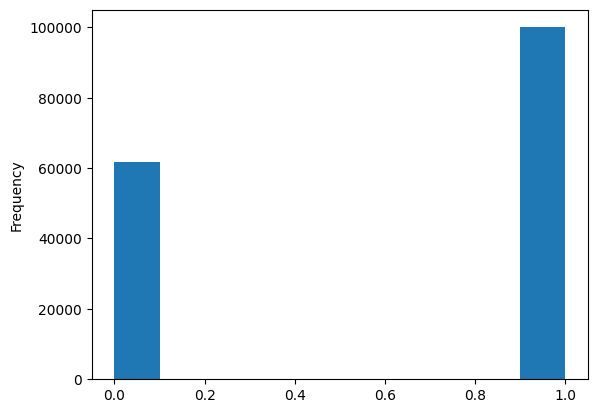

In [14]:
datos_recortados['Label'].plot(kind='hist')

285.59758555039065


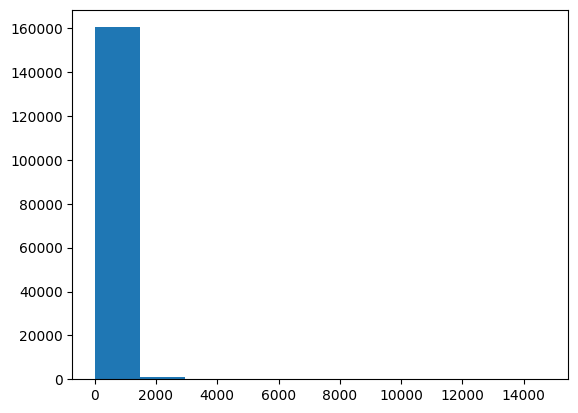

In [15]:
str_lengths = []
for row in datos_recortados['FullText']:
    str_lengths.append(len(row))

print(np.mean(str_lengths))
plt.hist(str_lengths)
plt.show()

### Entrenando un modelo de machine learning (NB)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(datos_recortados['FullText'], datos_recortados['Label'], test_size=0.3, random_state=42, stratify=datos_recortados['Label'])

In [27]:
tfidf = TfidfVectorizer(max_features=None)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [29]:
nb_classifier = MultinomialNB()

param_grid = {'alpha': np.arange(0, 1, 0.1),
              'fit_prior': [True, False]}

nb_classifier = GridSearchCV(nb_classifier, param_grid, cv=5, n_jobs=-1)

nb_classifier.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_prior': [True, False]})

In [30]:
best_alpha = nb_classifier.best_params_['alpha']
best_fit_prior = nb_classifier.best_params_['fit_prior']

print(f'Best alpha: {best_alpha}')
print(f'Best fit_prior: {best_fit_prior}')

Best alpha: 0.4
Best fit_prior: False


In [31]:
y_pred = nb_classifier.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83     18533
           1       0.90      0.89      0.89     30000

    accuracy                           0.87     48533
   macro avg       0.86      0.86      0.86     48533
weighted avg       0.87      0.87      0.87     48533



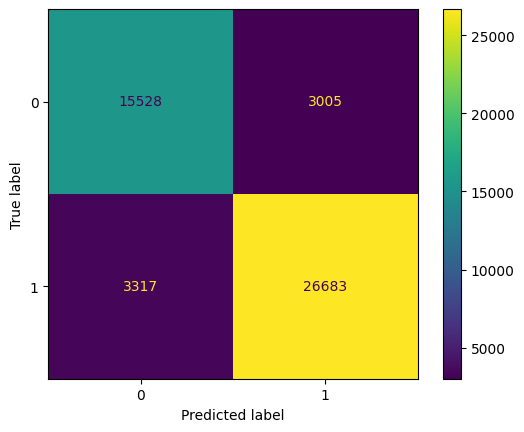

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()

### Entrenando un modelo tipo BERT

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
model_name = 'distilbert/distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
X_train, X_test, y_train, y_test = train_test_split(datos_recortados['FullText'], datos_recortados['Label'], test_size=0.3, random_state=42, stratify=datos_recortados['Label'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [19]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

In [20]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': list(y_train)
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': list(y_val)
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(y_test)
})

In [21]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    eval_strategy="epoch",    # Evaluar después de cada época
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    report_to="none"                # No reportar a Weights & Biases
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset
)

In [ ]:
trainer.train()

  0%|          | 28/14865 [00:21<2:59:22,  1.38it/s]